### First, run the cell below to load the libraries...


In [1]:


import osiris
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpmath import *
plt.rc('font',size=20,family="serif")
%matplotlib inline


## Landau Damping with UPIC-ES





### Introduction

Waves are a fundamental collective process in plasmas. The plasma state is rich in wave phenomena. One of the basic properties of plasmas, charge neutrality, is mediated by Langmuir waves. In most plasmas of interest, the ions are much heavier than the electrons and thus the ions move little compared to the electrons. When the electrons are displaced, an electric field develops to maintain charge neutrality, which accelerates the electrons back towards the ions. The electrons will overshoot and effectively slosh around the stationary ions. These oscillations are known by a variety of names: Langmuir oscillations, space charge waves, or simply plasma oscillations. For a stationary cold plasma, there are non-propagating modes at the plasma frequency. These modes become propagating modes when the plasma drifts at a constant speed. These can be studied in the fluid description if we choose an equation of state, i.e., if we have a model for pressure as a function of density and temperature.

#### Fluid Dispersion Relation
We consider a plasma with warm electrons and cold ions. First we choose the ideal equation of state, $P=\gamma \tilde{n}_e T_e$, where $\gamma \approx 3$ is the adiabatic index obtained from kinetic theory. We can then write the five linearized fluid equations. First we have the Navier-Stokes equations for both the electrons and ions, respectively:

\begin{equation}
		\frac{\partial}{\partial t}\tilde{\mathbf{v}}_e=-\frac{e}{m_e}\tilde{\mathbf{E}}-\frac{\gamma T_e}{m_e n_{0e}}\nabla \tilde{n}_e\\
		\frac{\partial}{\partial t} \tilde{\mathbf{v}}_i=\frac{Ze}{m_i}\tilde{\mathbf{E}}.
\end{equation}

The continuity equations are

\begin{equation}
		\frac{\partial}{\partial t}\tilde{n}_e+\nabla \cdot [n_{0e}\tilde{\mathbf{v}}_e]=0\\
		\frac{\partial}{\partial t}\tilde{n}_i+\nabla \cdot [n_{0i}\tilde{\mathbf{v}}_i]=0,
\end{equation}

and finally Poisson's equation is given as
\begin{equation}
	\nabla \cdot \tilde{\mathbf{E}}=-4 \pi e (\tilde{n}_e-Z\tilde{n}_i).
\end{equation}
We then take the divergence of the Navier-Stokes equations and the time derivative of the continuity equations and combine. We then go Fourier space by assuming plane wave solutions, i.e., $\partial_t \rightarrow -i\omega$ and $\nabla \rightarrow ik$. Solving the resulting equation for $\tilde{n}_e$ gives
\begin{equation}
	\tilde{n}_e=\frac{-\frac{e n_{0e}}{m_e}i\mathbf{k}\cdot\tilde{\mathbf{E}}}{\omega^2-\frac{\gamma T_e k^2}{m_e n_{0e}}}
\end{equation}
We get a similar result for ions, but without the pressure term. We then substitute these into Poisson's Equation and collect terms to get
\begin{equation}
	\left( 1-\frac{\omega_{pi}^2}{\omega ^2}-\frac{\omega_{pe}^2}{\omega^2-\frac{\gamma T_e k^2}{m_e n_{0e}}}\right) \mathbf{k}\cdot\tilde{\mathbf{E}}=0.
\end{equation}
Since $\nabla \cdot \tilde{\mathbf{D}} = \nabla \cdot (\epsilon \tilde{\mathbf{E}}) = \epsilon \mathbf{k} \cdot \tilde{\mathbf{E}}$, the term in parenthesis is then our dielectric constant. Setting this equal to zero gives the dispersion relation,
\begin{equation}
	\omega^2=\omega_{pe}^2+\gamma \bar{v}_e^2 k^2,
\end{equation}
where $\bar{v}_e^2=T_e/m_e$, and we have neglected the ion contribution because it is small compared to the electron contribution for Langmuir waves. So we see that the pressure term provides an additional term to the dispersion relation (the stationary solution is just $\omega^2=\omega_{pe}^2$).

### Kinetic Dispersion Relation:

The Langmuir description (shown above) lacks kinetic damping. A more accurate (and complete) dispersion relation, which includes kinetic effects, can be obtained by treating the plasma wave problem as an initial value problem and use a Laplace transform in time and allows for damping.  Following this line of logic, the plasma dispersion becomes: 

\begin{equation}
\epsilon(\omega,k) = 1 + \sum_{s} \chi_s(\omega,k)
\end{equation}

with no approximation, and taking causality into account, the plasma susceptibility $\chi_s$ can be written as (the full derivation can be found in the classic paper by Landau):
\begin{equation}
\chi_s (\omega,k) = \left( \frac{\omega_{p,s}}{k v_{t,s} } \right)^2 
Z'(\frac{\omega} {\sqrt{2}k v_{t,s}} )
\end{equation}
Therefore, for a Maxwellian plasma and infinitely massive, cold ion, the plasma dispersion relation becomes:
\begin{equation}
1 - 0.5 * \left( \frac{\omega_{p,e}}{k v_{t,e} } \right)^2 
Z'(\frac{\omega} {\sqrt{2}k v_{t,e}} ) = 0
\end{equation}

The above expression do not yield to easy expresssions, but some asymptotic limits are available.  For example, for very large phase velocities, or $k \lambda_D < 0.25$, the Bohm-Gross dispersion relation (shown above) works very well.  

In the weak damping limit, one can obtain an approximation for the damping rate.  This is given both in the original paper by Landau (equation (1.2)) and a more accurate expression was also obtained by J. D. Jackson in 1960 (equation (6.3) in J. D. Jackson, J. Nucl. Eng. Part C Plasma Physics 1, 171 (1960).) For a small range of $k \lambda_D$, typically $k \lambda_D < 0.5$ (as shown in Figure (3) of the Jackson paper), the damping rate can be approximated by the expression:  

\begin{equation}
 \gamma /\omega << 1
\end{equation}



\begin{equation}
\gamma = \frac{ \epsilon_I(k,\omega(k))}
{\frac{\partial}{\partial \omega} \epsilon_R(k,\omega(k))}\\
\end{equation}

\begin{equation}
\gamma = - \sqrt{\frac{\pi}{8}} \frac{1}{(k \lambda_D)^3} \ exp(-\frac{2}{3}) \ \
exp \left(- \left({\frac{k_D}{\sqrt{2}k}}\right)^2 \right)
\end{equation}

Below we first plot the exact result vs the Jackson estimate for a large range of $k \lambda_D$.







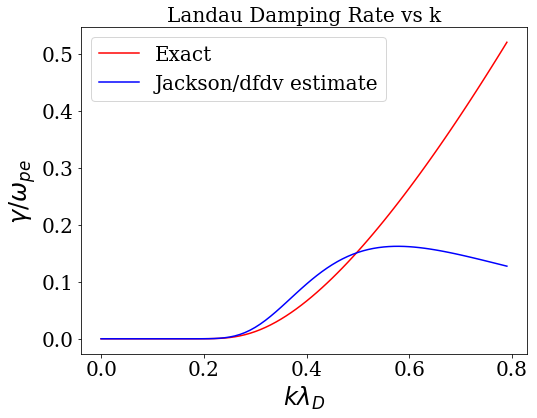

NameError: name 'cubic' is not defined

In [5]:
karray=np.arange(0.0,0.8,0.01)
damping=osiris.landau(karray)
damping_estimate=np.sqrt(np.pi/8)*1.0/(karray*karray*karray+1e-5)*np.exp(-1.5)*np.exp(-1/(2*karray*karray+1e-5))
damping_estimate[0]=0.0
   
plt.figure(figsize=(8,6))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 
plt.plot(karray,np.abs(damping),'r',label='Exact')
plt.plot(karray,damping_estimate,'b',label='Jackson/dfdv estimate')
plt.xlabel('$k \lambda_D$')
plt.ylabel('$\gamma/\omega_{pe}$')
plt.title('Landau Damping Rate vs k')
plt.legend()
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 32
  
plt.show()
landau_exact=scipy.interpolate.interp1d(karray,np.abs(damping),kind=cubic)
landau_estimate=scipy.interpolate.interp1d(karay,damping_estimate,kind=cubic)

In [27]:
dirname = 'landau-kd035'
osiris.run_upic_es(rundir=dirname,inputfile='landau-kd035.txt')

combine_h5_2d completed normally
runbeps completed normally


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


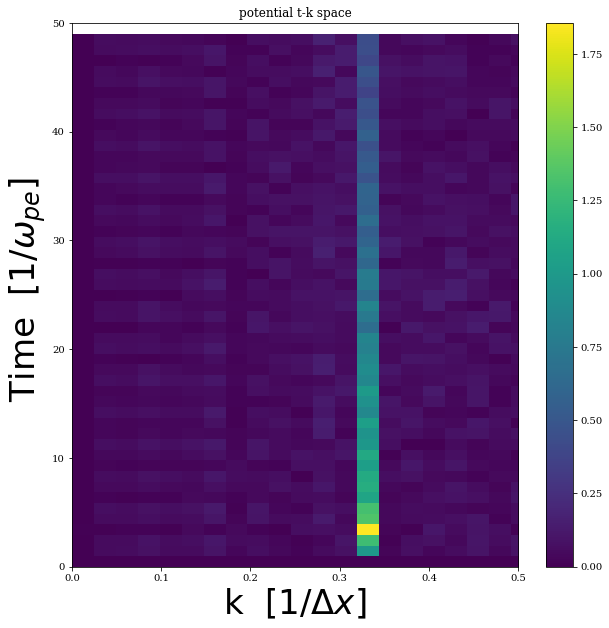

In [28]:
dirname = 'landau-kd035'

osiris.plot_tk_arb(dirname,'Ex',klim=0.5,tlim=50)
#rundir, field, title='potential', klim=5,tlim=100

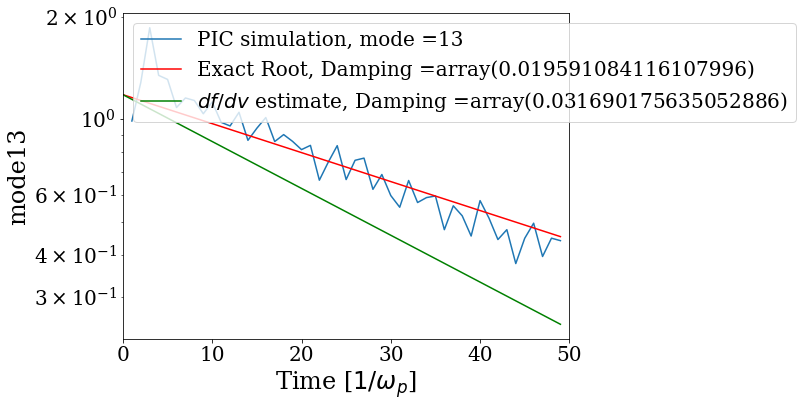

In [6]:
dirname = 'landau-kd035'
landau_exact=scipy.interpolate.interp1d(karray,np.abs(damping),kind='cubic')
landau_estimate=scipy.interpolate.interp1d(karray,damping_estimate,kind='cubic')
theory_exact=landau_exact(26.0*np.pi/256.0)
theory_estimate=landau_estimate(26.0*np.pi/256.0)
osiris.plot_tk_landau_theory(dirname,'Ex',modeno=13,theory1=theory_exact,theory2=theory_estimate,init_amplitude=1.18,tlim=50)
#rundir, field, title='potential', klim=5,tlim=100

In [3]:
dirname = 'landau-kd054'
osiris.run_upic_es(rundir=dirname,inputfile='landau-kd054.txt')

combine_h5_2d completed normally
runbeps completed normally


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


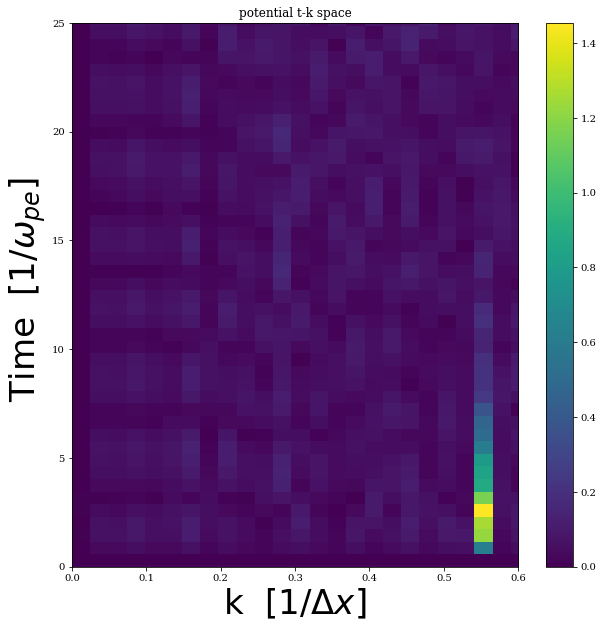

In [26]:
dirname = 'landau-kd054'


osiris.plot_tk_arb(dirname,'Ex',klim=0.6,tlim=25)
#rundir, field, title='potential', klim=5,tlim=100

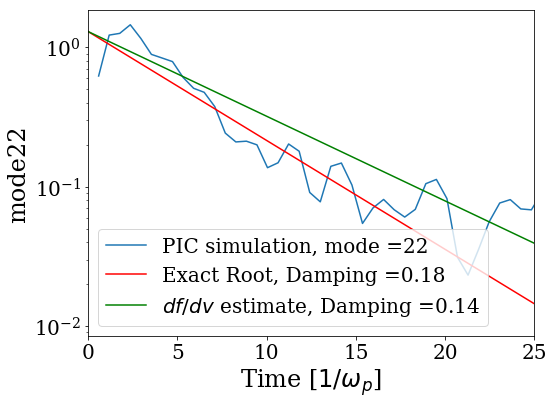

In [7]:
dirname = 'landau-kd054'

landau_exact=scipy.interpolate.interp1d(karray,np.abs(damping),kind='cubic')
landau_estimate=scipy.interpolate.interp1d(karray,damping_estimate,kind='cubic')
theory_exact=landau_exact(44.0*np.pi/256.0)
theory_estimate=landau_estimate(44.0*np.pi/256.0)
osiris.plot_tk_landau_theory(dirname,'Ex',modeno=22,theory1=0.18,theory2=0.14,init_amplitude=1.3,tlim=25)
#rundir, field, title='potential', klim=5,tlim=100